# Monte Carlo and portfolios

We saw how to simulate the price of an asset back when we looked at the price of [Bitcoin](7_nasdaq_api.html#btc-sim) and using the Nasdaq API. We are going to take a more complete look here at **simulating correlated assets within a portfolio**. These methods can be used for measuring portfolio risk, for simulating client portfolios in a [financial planning setting](https://www.kitces.com/blog/volatility-drag-variance-drain-mean-arithmetic-vs-geometric-average-investment-returns/), or [pricing complex options](https://en.wikipedia.org/wiki/Monte_Carlo_methods_for_option_pricing) like [Asian options](https://en.wikipedia.org/wiki/Asian_option).

I am basing a lot of my code and discussion on this [blog post](https://medium.com/codex/simulate-multi-asset-baskets-with-correlated-price-paths-using-python-472cbec4e379).

This material is related to the [Heston model](https://www.codearmo.com/python-tutorial/heston-model-simulation-python) for simulating the prices of correlated assets. The volatility of the assets are linked together. In the Heston model, the volatility of an asset today is also related to past volatility. We'll do more on this when we get to [GARCH models](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity).

We'll also use **yfinance** to bring in some stock prices from Yahoo! finance. You'll need to run `pip install yfinance` in the terminal. You can read more about it [here](https://pypi.org/project/yfinance/).

## How correlation affects our simulations

However, when we start to form portfolios, we are going to care about the correlations across assets. We've already seen this when looking at portfolio math. When simulating the Bitcoin prices, we took random numbers from the standard normal distribution and then scaled them by our estimate for the volatility of BTC. This allowed us to capture the randomness of the returns.

However, when dealing with more than one asset, we can't do that, since the assets are **not independent** from one another. If Apple goes up, Google is more likely to have gone up as well. The two stocks are **correlated**. How can we account for this in our simulation? We will create **correlated random shocks** ($W$), where the random movement of one asset depends on another assets movement.

Let's try a simulation to see what's going on. I'll draw two random variables from the standard normal distribution, N(0,1). The random part of the return for Asset 1, $W_1$, is simply the random draw, $x_1$. However, the random part of the return for Asset 2, $W_2$, is correlated with whatever $x_1$ ends up being. Mathematically, this dependent random movement is given as:

\begin{align}
W_2 = \rho x_1 + (1 - \sqrt{\rho^2}) x_2
\end{align}

I'll set the correlation, $\rho$, to be -0.80. These two assets are negatively correlated, so they should move in opposite directions. We'll set each asset to have the same mean return and same volatility. I'll set the starting price of each of these assets to 1.

We'll bring in our usual packages and try this out. This code should look a lot like the Bitcoin code, except that I now have two assets. I am only doing one simulation for each asset, so two total simulations.

How do we simulative prices? Let me remind you of a formula:

\begin{align}
S(t) = S(0) \exp \left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W(t)\right)
\end{align}

Take a starting price $S_0$. We use `exp` for continuous compounding. Then, the price today, $S_t$ is a function of two return sources. The first source is called **drift**: $\mu - \frac{1}{2}\sigma^2$. This is what an asset returns on average over some period, like a day. This is the **deterministic** piece of the return and would be related to risk. $\mu$ is the **arithmetic average** and $\sigma$ is the volatility (standard deviation). They should be in the same units (e.g. daily).

The second piece of the return is the **diffusion**: $\sigma W(t)$. $W(t)$ is called a **Brownian motion** and is, essentially, cumulative random wiggles. You multiply by $\sigma$ to scale it: more volatility, more wiggles.

$dW$ denotes the random wiggle in just one period. 

In this example, our random wiggles are going to be **correlated** across assets.

In [1]:
import datetime
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Include this to have plots show up in your Jupyter notebook.
%matplotlib inline 

In [2]:
T = 251 # How long is our simulation? Let's do 252 days (0 to 251)
N = 251 # number of time points in the prediction time horizon, making this the same as T means that we will simulate daily returns 

rho = -0.80 # Correlation between our two assets. Change me to get different patterns!
mu = 0.05/252 # Mean return (log). Using daily. 
sigma = 0.12/np.sqrt(252)  # Volatility of returns (standard deviation). Using daily. 
drift = mu - 0.5 * sigma ** 2 # Drift is the same each day.

S_0 = 1 # Starting price

dt = T/N # One day price movements
dW = np.zeros([2, N]) # Set up random shocks with zeroes for now

# Sample two random variables from the standard normal distribution standard normal distribution. Two rows of 251 values from N(0,1).
X = np.random.normal(scale = np.sqrt(dt), size=(2, N))

# Generate correlated random shock, W. 
dW[0] = X[0] # Same as first row in X
dW[1] = rho * X[0] + (1 - np.sqrt(rho**2)) * X[1] # Dependent on both sets of random values. How dependent? Correlation determines.

#An array containing the sum of random shocks for our assets.
W = np.cumsum(dW, axis=1) 

diffusion = sigma * W # This is CUMULATIVE diffusion returns over time, rather than daily diffusion returns. 

time_step = np.linspace(dt, T, N) # An array of 1, 2, 3, 4, 5..., keeping track of what time period we are in.
time_steps = np.broadcast_to(time_step, (2, N)) # An array of 1, 2, 3, 4, 5..., but for each asset. 

# This is taking the drift (mu - 0.5 * sigma ** 2), which is the same each day, and multiplying it by 1 on Day 1, 2 on Day 2, 3 on Day 3, etc. Then, that term has sigma (volatility) * the cumulative shock added to it. 
# Then, Staring Price * e^(r) = Price Today, since r is really a cumulative return.
S_t = S_0 * np.exp((drift) * time_steps + diffusion) 

S_t = np.insert(S_t, 0, S_0, axis=1)

Let's plot the two sets of cumulative returns to see if they make sense.

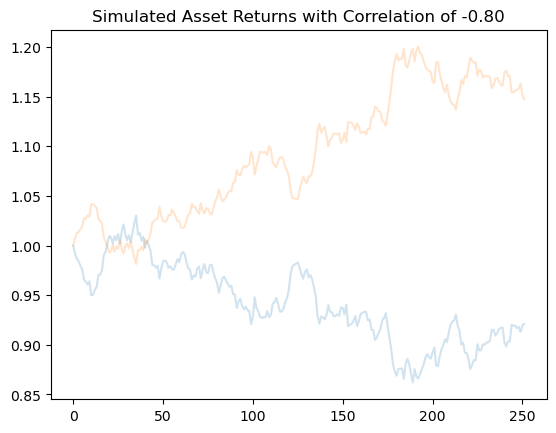

In [3]:
sims = pd.DataFrame(np.transpose(S_t))

# plotting
ax = sims.plot(alpha=0.2, legend=False)

ax.set_title('Simulated Asset Returns with Correlation of -0.80', fontsize=12);

You can really see the negative correlation!

Let's move to some real data now. I am using `yfinance` to bring in price and volume data. I then keep just the adjusted closing prices for five stocks. Finally, I can calculate discrete returns and check my descriptives.

In [4]:
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
ticker_list = ["AAPL", "F", "CAG", "AMZN", "XOM"]

stock_data = yf.download(ticker_list, start_date, end_date)

prices = stock_data['Adj Close']

rets = prices.pct_change().dropna()

[                       0%                       ]

[                       0%                       ]

[**********************80%*************          ]  4 of 5 completed

[*********************100%***********************]  5 of 5 completed

In [5]:
stock_data

Adj Close                                                 Close  \
                 AAPL       AMZN        CAG         F        XOM       AAPL   
Date                                                                          
2019-01-02  37.893337  76.956497  17.998070  6.351992  53.962505  39.480000   
2019-01-03  34.118881  75.014000  18.192139  6.255506  53.133987  35.547501   
2019-01-04  35.575386  78.769501  18.445278  6.496721  55.093014  37.064999   
2019-01-07  35.496204  81.475502  18.824984  6.665571  55.379524  36.982498   
2019-01-08  36.172878  82.829002  18.090879  6.729895  55.782158  37.687500   
...               ...        ...        ...       ...        ...        ...   
2019-12-24  69.236229  89.460503  29.664688  8.119876  56.814785  71.067497   
2019-12-26  70.609909  93.438499  29.351059  8.102728  56.904049  72.477501   
2019-12-27  70.583099  93.489998  29.777948  8.025559  56.709309  72.449997   
2019-12-30  71.002045  92.344498  29.655977  7.931242  56.376633  72.879997   
2019-12-31  71.520821  92.391998  29.830225  7.974113  56.620049  73.412498   

                                                   ...       Open             \
                 AMZN        CAG     F        XOM  ...       AAPL       AMZN   
Date                                               ...                         
2019-01-02  76.956497  21.330000  7.90  69.690002  ...  38.722500  73.260002   
2019-01-03  75.014000  21.559999  7.78  68.620003  ...  35.994999  76.000504   
2019-01-04  78.769501  21.860001  8.08  71.150002  ...  36.132500  76.500000   
2019-01-07  81.475502  22.309999  8.29  71.519997  ...  37.174999  80.115501   
2019-01-08  82.829002  21.440001  8.37  72.040001  ...  37.389999  83.234497   
...               ...        ...   ...        ...  ...        ...        ...   
2019-12-24  89.460503  34.049999  9.47  70.019997  ...  71.172501  89.690498   
2019-12-26  93.438499  33.689999  9.45  70.129997  ...  71.205002  90.050499   
2019-12-27  93.489998  34.180000  9.36  69.889999  ...  72.779999  94.146004   
2019-12-30  92.344498  34.040001  9.25  69.480003  ...  72.364998  93.699997   
2019-12-31  92.391998  34.240002  9.30  69.779999  ...  72.482498  92.099998   

                                           Volume                       \
                  CAG     F        XOM       AAPL       AMZN       CAG   
Date                                                                     
2019-01-02  21.139999  7.53  67.349998  148158800  159662000   9529800   
2019-01-03  21.270000  7.97  70.000000  365248800  139512000   8526000   
2019-01-04  21.690001  7.91  69.639999  234428400  183652000  10307800   
2019-01-07  21.850000  8.11  71.250000  219111200  159864000   7688400   
2019-01-08  22.120001  8.42  72.540001  164101200  177628000  12699700   
...               ...   ...        ...        ...        ...       ...   
2019-12-24  34.060001  9.44  70.349998   48478800   17626000   2459600   
2019-12-26  33.959999  9.47  70.190002   93121200  120108000   4672700   
2019-12-27  33.770000  9.45  70.199997  146266000  123732000   2574400   
2019-12-30  34.119999  9.34  70.089996  144114400   73494000   1813200   
2019-12-31  34.119999  9.25  69.019997  100805600   50130000   2558500   

                                
                   F       XOM  
Date                            
2019-01-02  47494400  16727200  
2019-01-03  39172400  13866100  
2019-01-04  43039800  16043600  
2019-01-07  40729400  10844200  
2019-01-08  45644000  11439000  
...              ...       ...  
2019-12-24  11881600   3979400  
2019-12-26  28961300   8840200  
2019-12-27  28272800  10516100  
2019-12-30  36074900  12689400  
2019-12-31  32342100  13151800  

[252 rows x 30 columns]

In [6]:
rets

,AAPL,AMZN,CAG,F,XOM
Date,,,,,
2019-01-03,-0.099607,-0.025241,0.010783,-0.015190,-0.015354
2019-01-04,0.042689,0.050064,0.013915,0.038560,0.036870
2019-01-07,-0.002226,0.034353,0.020586,0.025990,0.005200
2019-01-08,0.019063,0.016612,-0.038996,0.009650,0.007270
2019-01-09,0.016981,0.001714,-0.002798,0.041816,0.005275
...,...,...,...,...,...
2019-12-24,0.000951,-0.002114,0.000882,0.003178,-0.003841
2019-12-26,0.019840,0.044467,-0.010572,-0.002112,0.001571
2019-12-27,-0.000380,0.000551,0.014544,-0.009524,-0.003422


In [7]:
rets.describe()

,AAPL,AMZN,CAG,F,XOM
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.002671,0.000832,0.002271,0.001053,0.000257
std,0.016498,0.014382,0.022887,0.017158,0.011500
min,-0.099607,-0.053819,-0.120982,-0.074540,-0.040290
25%,-0.004820,-0.006649,-0.008724,-0.006961,-0.006711
50%,0.002768,0.001163,0.002337,0.000965,0.000694
75%,0.011561,0.008535,0.013240,0.010034,0.007803
max,0.068334,0.050064,0.158692,0.107447,0.036870


Seems legit! The average daily returns are all positive, but around zero. The worst daily return is an Apple return of -9.96%. Each stock has a count of 251 daily returns over the course of the year.

OK, now it's time to set up our simulation. We will do 50 different future portfolio paths. We'll simulate 252 days worth of prices. We'll use these prices to find returns.

We are simulating random numbers. But, computers cant *really* generate truly random numbers. We can set a **seed** value that will always generate the same set of random values. 

`mu` has our arithmetic average returns. 

We then find our usual variance-covariance matrix using `.cov()`.

In [8]:
np.random.seed(1986)

T = 252 # How long is our simulation? Let's do 252 days.
N = 252 # number of time points in the prediction time horizon, making this the same as T means that we will simulate daily returns 
N_SIM = 50  # How many simulations to run?
dt = T/N # daily steps
noa = 5 # Number of assets

weights = np.array(noa * [1. / noa,])  # EW portfolio based on number of assets. You can change this array to have any weights you want.

mu = rets.mean()
cov = rets.cov()
sigma = rets.std()
corr = rets.corr()

# initial matrix
port_returns_all = np.full((T-1, N_SIM), 0.) # One less return than price

We can look at the actual correlations among our assets to get a sense of what we are using to form portfolios.

In [9]:
corr

,AAPL,AMZN,CAG,F,XOM
AAPL,1.000000,0.592889,0.152909,0.305896,0.416557
AMZN,0.592889,1.000000,0.116091,0.364217,0.370258
CAG,0.152909,0.116091,1.000000,0.066562,0.160015
F,0.305896,0.364217,0.066562,1.000000,0.375396
XOM,0.416557,0.370258,0.160015,0.375396,1.000000


Let's start with a simple case. We'll simulate one series of returns for each of our assets, but include **correlated shocks**. We'll get returns by actually simulating prices and then calculating returns.

The first line picks out he latest prices for each stock. This is where we will start. You could start each stock at \$1 and get the same return result, since it's the change that matters.

The second line is our **math magic**. This takes our variance-covariance matrix and does something called the **Cholesky Decomposition**. The variance-covariance matrix contains the information for how our assets move together (i.e. covariance). This method will allow us to use the **correlation among our assets** when simulating the random price paths. We want correlated assets to move together. You can read more about these methods [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4066115). 

`A` is a $5\times5$ matrix, just like the variance-covariance matrix, but the upper triangular part is all zeroes, while the lower triangular part still contains the dependencies among our assets. 

`S` is 252 days of "empty" prices for our 5 assets. Why 252? We want our starting price plus 251 days of simulated prices. We'll fill these in with simulated prices. We make the first price in the array equal to the latest price.

Then, we have a `for` loop that simulates prices for each asset across all 252 days. Ranges in Python start at and include the first, but stop one before the last number. Why do we start at 1? S[:, 0] are our initial prices. See how the fourth line has `i-1`. So, the first time through, it will use the starting price `S[:,1-1]`, or `S[:,0]`, to find the first simulated price `S[:,1]`. The loop will then go to 252 and stop one before, or 251. This gives us a starting price plus 251 daily simulated prices. Counting isn't always easy! 

We first calculate the **drift**, or deterministic component, of the return. This is based on the mean and standard deviation of the returns. `dt` is just 1 day in this case.

We then pull 5 random variables, one for each asset, from the standard normal distribution. We'll call these 5 numbers `Z`. 

If you multiply `A` and `Z`, then you get correlated standard normal variables, instead of five sets of random variables with no relationships among them.

The last line in the `for` loop is again how we simulate prices. I have done the drift (deterministic) and diffusion (random) terms separately to make it easier to see what's going on. With this type of simulation, the stock price today is the stock price yesterday times $\exp(\text{drift} + \text{diffusion})$. This is **continuous compounding**. 

I take these prices and calculate returns again. But, these are now one set of simulated returns.

Finally, I take the returns and multiply them by our chosen weights to get a single set of **portfolio returns**.

In [10]:
S_0 = prices.iloc[-1]
A = np.linalg.cholesky(cov)
S = np.zeros([noa, N]) # Why N+1? We want our starting price + 252 days of prices.
S[:, 0] = S_0

for i in range(1, N):    
    drift = (mu - 0.5 * sigma**2) * dt # dt = 1. This is the deterministic part of the daily return. It's the same every day.
    Z = np.random.normal(0., 1., noa) # Putting as period after a number in Python makes division work correctly when dealing with integers. Not sure we even need it here.
    diffusion = np.matmul(A, Z) * np.sqrt(dt) # dt = 1. This is the random part. 
    S[:, i] = S[:, i-1]*np.exp(drift + diffusion) # S_t = S_t-1 * e^(r). Continuous compounding, where r is just that day's return, rather than a cumulative return. 

R = pd.DataFrame(S.T).pct_change().dropna() # Create returns from those simulated prices.

port_rets = np.cumprod(np.inner(weights, R) + 1) # Weights x returns, cumulative product to get cumulative portfolio returns.

This method is coded up a bit differently from the two-asset and BTC example. There are no `timesteps`. Instead, `dt` = 1. Each previous stock return S_t-1 is being multiplied by a single daily return (drift+diffusion), rather than a cumulative return. 

```{hint}
I recommend running each line separately and then looking at the resulting variable/array. This is how you can figure out what's going on in the simulation.
```

Let's check the correlations and descriptives for these simulated returns. 

In [11]:
R.corr()

,0,1,2,3,4
0,1.000000,0.595472,0.266348,0.304452,0.501392
1,0.595472,1.000000,0.213024,0.387221,0.443720
2,0.266348,0.213024,1.000000,0.156466,0.257572
3,0.304452,0.387221,0.156466,1.000000,0.349658
4,0.501392,0.443720,0.257572,0.349658,1.000000


In [12]:
R.describe()

,0,1,2,3,4
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.001904,0.000292,0.000791,0.000038,-0.000043
std,0.016625,0.014635,0.023678,0.017270,0.011896
min,-0.045377,-0.038192,-0.067844,-0.049063,-0.034151
25%,-0.010133,-0.008758,-0.014598,-0.011360,-0.008491
50%,0.001480,-0.001245,-0.000619,0.000610,-0.000171
75%,0.010484,0.010548,0.018418,0.012514,0.007760
max,0.045815,0.040962,0.061667,0.044706,0.032788


They seem to make sense! The simulated correlations, in particular, are close to the empirical correlations. 

Finally, let's add **one more element to this loop**. We can find 50 different portfolio returns by wrapping the code above in another `for` loop.

The first loop is counting a bit differently. Our first simulation is indexed at 0 in Python. We will go up to, but not include the number of simulations we are doing. So, 0 through 49. This gives us 50 total simulations.

Remember, the **indentation** matters! It tells us how the loops are **nested**. 


In [13]:
S_0 = prices.iloc[-1]
A = np.linalg.cholesky(cov)
S = np.zeros([noa, N])
S[:, 0] = S_0

for t in range(0, N_SIM):
    for i in range(1, N):    
        drift = (mu - 0.5 * sigma**2) * dt 
        Z = np.random.normal(0., 1., noa) 
        diffusion = np.matmul(A, Z) * np.sqrt(dt) 
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion) 

        R = pd.DataFrame(S.T).pct_change().dropna()

        port_rets = np.cumprod(np.inner(weights, R) + 1)
    port_returns_all[:, t] = port_rets

I don't claim that this is elegant code. I'm sure there's a better way to do this via vectorization, without loops.

Let's graph these 50 different portfolio paths to see what our future may hold.

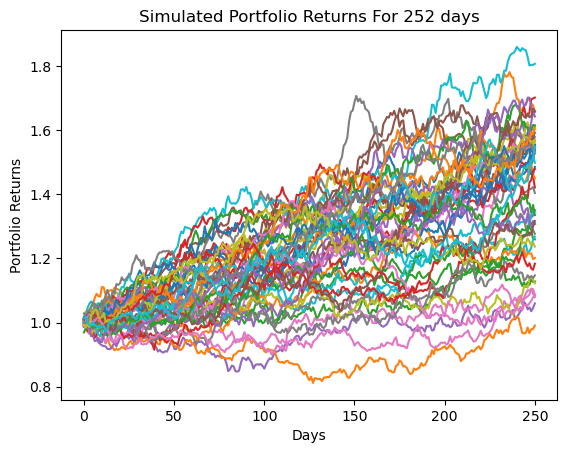

In [14]:
port_returns_all = pd.DataFrame(port_returns_all)

plt.plot(port_returns_all)
plt.ylabel('Portfolio Returns')
plt.xlabel('Days')
plt.title('Simulated Portfolio Returns For 252 days');

That's a large spread of possible cumulative portfolio returns over the year! This type of simulation is potentially useful for financial planners, and let's you "answer" questions like, "What's the probability that my portfolio falls below a particular level over the next decade?". You can also use price paths like this to price certain options, where the value of the option depends on the paths that a basket of stocks took. 